# Human MRI with resected tissue example
We map between two human MRIs from mricloud.org at 1mm resolution.  These images are both affine aligned to MNI space.  We simulate resected tissue in the target image.

## Library imports
We start by importing necessary libraries.  That includes numpy, matplotlib, and tensorflow for numerical work, nibabel for loading neuroimages, and lddmm and vis which are part of this library.

In [1]:
import numpy as np # for arrays
%matplotlib notebook
import matplotlib as mpl # for graphics
import matplotlib.pyplot as plt
import nibabel as nib # for loading neuroimages
import lddmm # algorithm
import vis # visualization
import tensorflow as tf
import imp # use imp.reload to update modules during development

importing vis


In [2]:
# get filenames
atlas_image_fname = 'Adt27-55_02_Adt27-55_02_MNI.img'
target_image_fname = 'Adt27-55_03_Adt27-55_03_MNI.img'

In [3]:
# load them with nibabel
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [4]:
# get info about image space
if '.img' == atlas_image_fname[-4:]:    
    nxI = img[0].header['dim'][1:4]
    dxI = img[0].header['pixdim'][1:4]
    nxJ = img[1].header['dim'][1:4]
    dxJ = img[1].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]
xJ = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJ,dxJ)]

In [6]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]

<IPython.core.display.Javascript object>


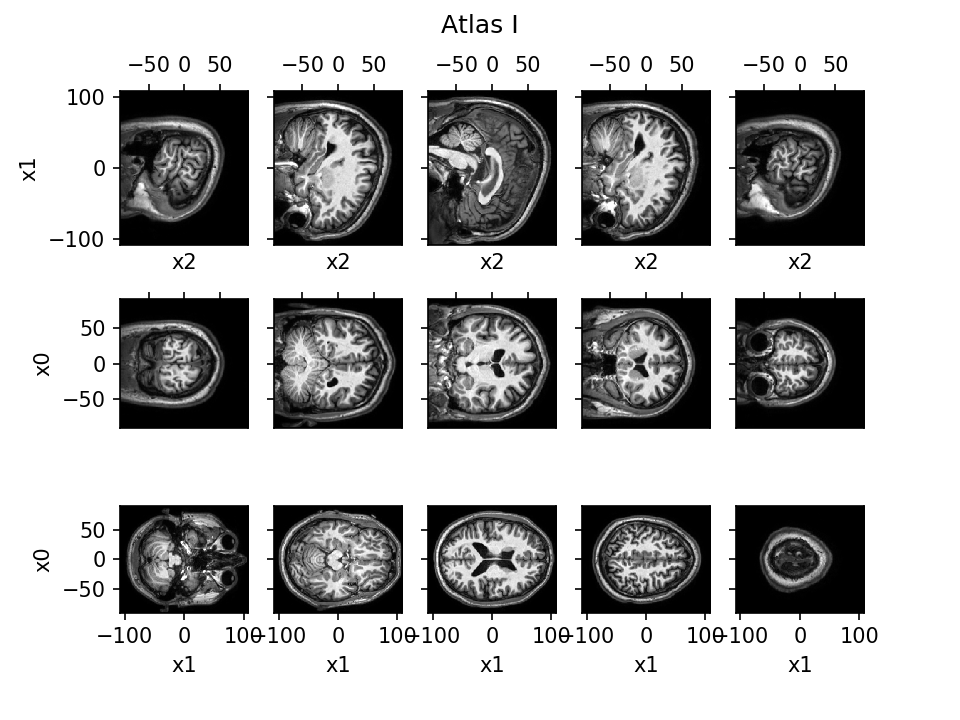

In [7]:
# display the data
f = plt.figure()
vis.imshow_slices(I, x=xI, fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

<IPython.core.display.Javascript object>


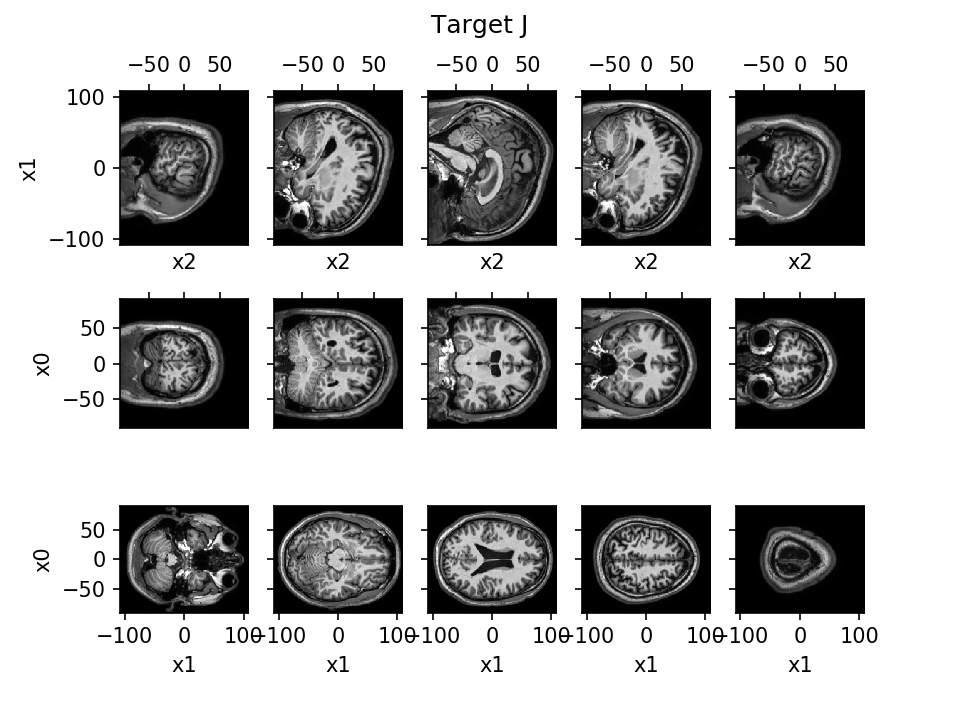

In [8]:
f = plt.figure()
vis.imshow_slices(J,x=xJ,fig=f)
f.suptitle('Target J')
f.canvas.draw()

<IPython.core.display.Javascript object>


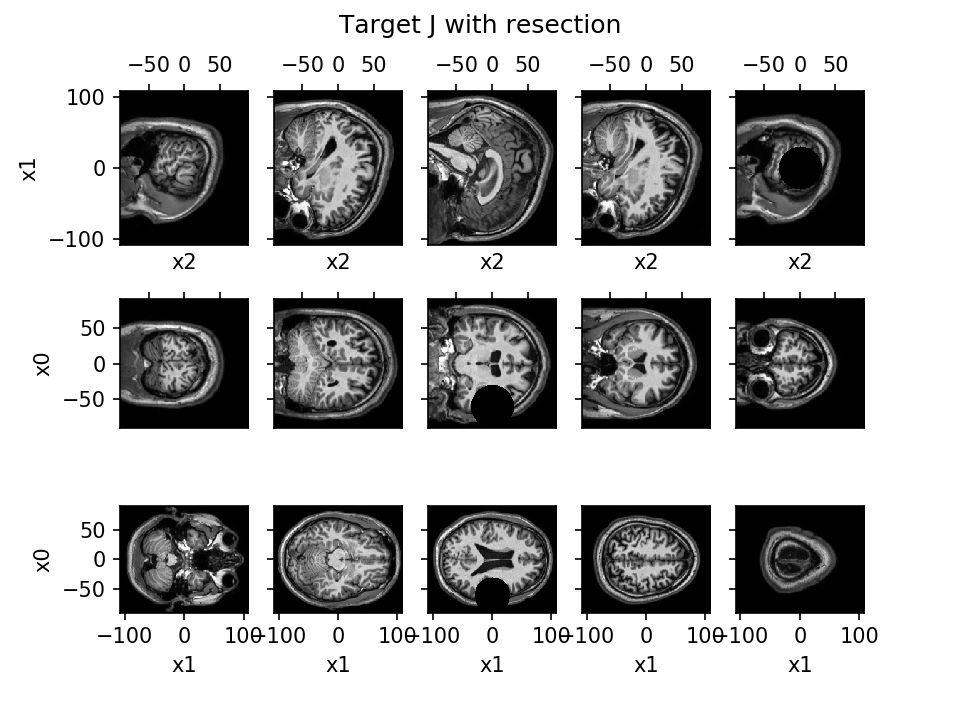

In [9]:
# simulate some resected data, just a big wohle
XJ = np.meshgrid(*xJ,indexing='ij')
resected = (XJ[0] - 60)**2 + (XJ[1])**2 + (XJ[2])**2 <= (30)**2
f = plt.figure()
vis.imshow_slices(J*(1.0-resected),x=xJ,fig=f)
f.suptitle('Target J with resection')
f.canvas.draw()

## Run DR IT MD image matching

Set default parameters
Initial affine transform [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Got parameters


<IPython.core.display.Javascript object>


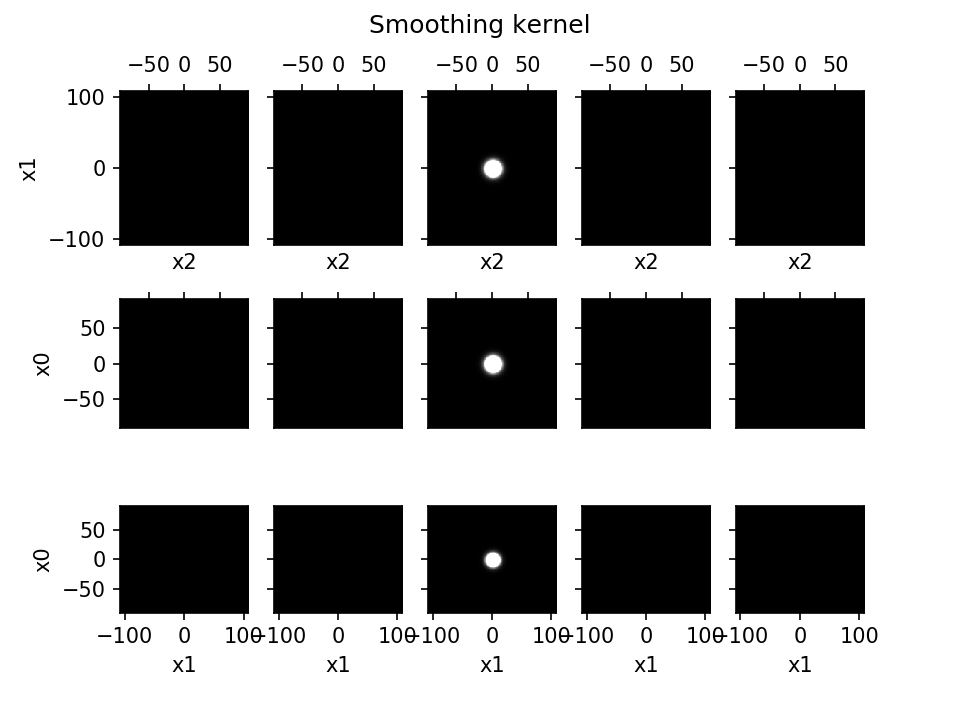

Built energy operators
Built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


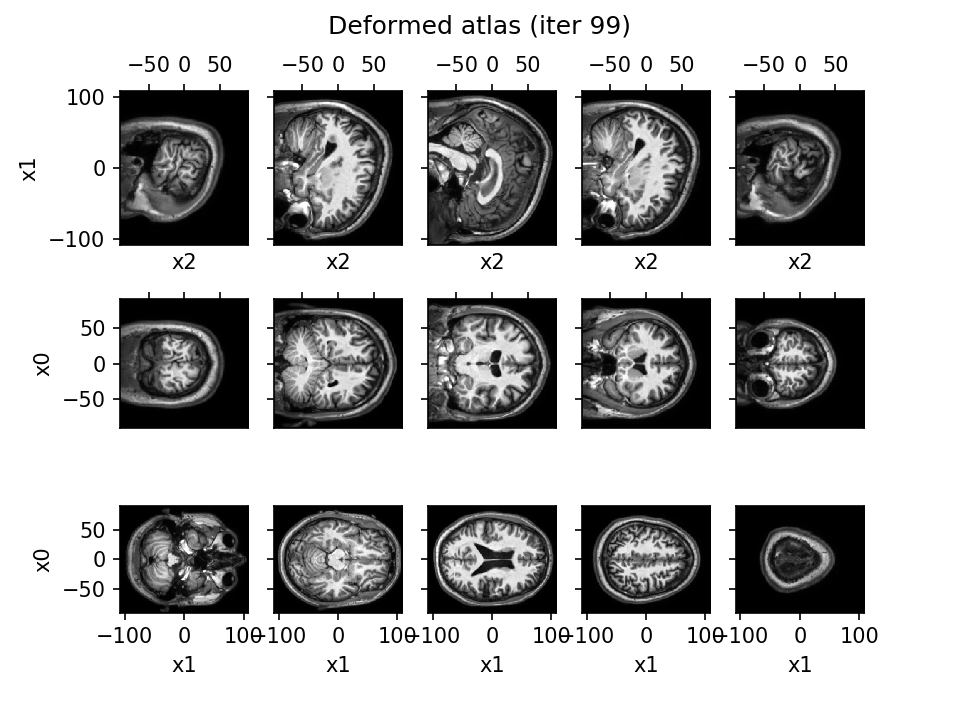

<IPython.core.display.Javascript object>


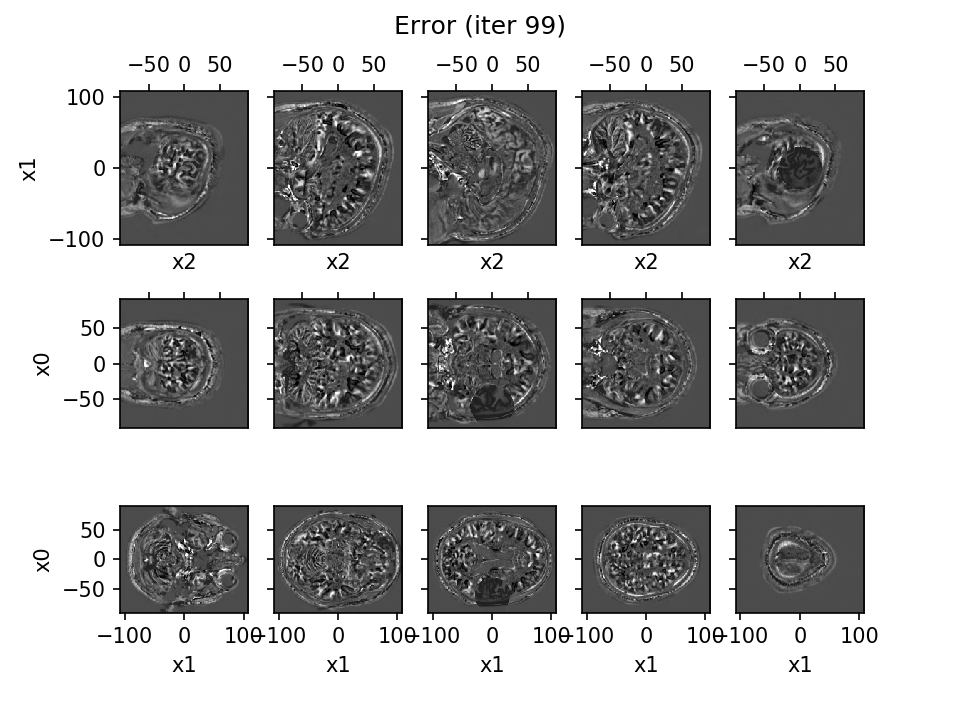

<IPython.core.display.Javascript object>


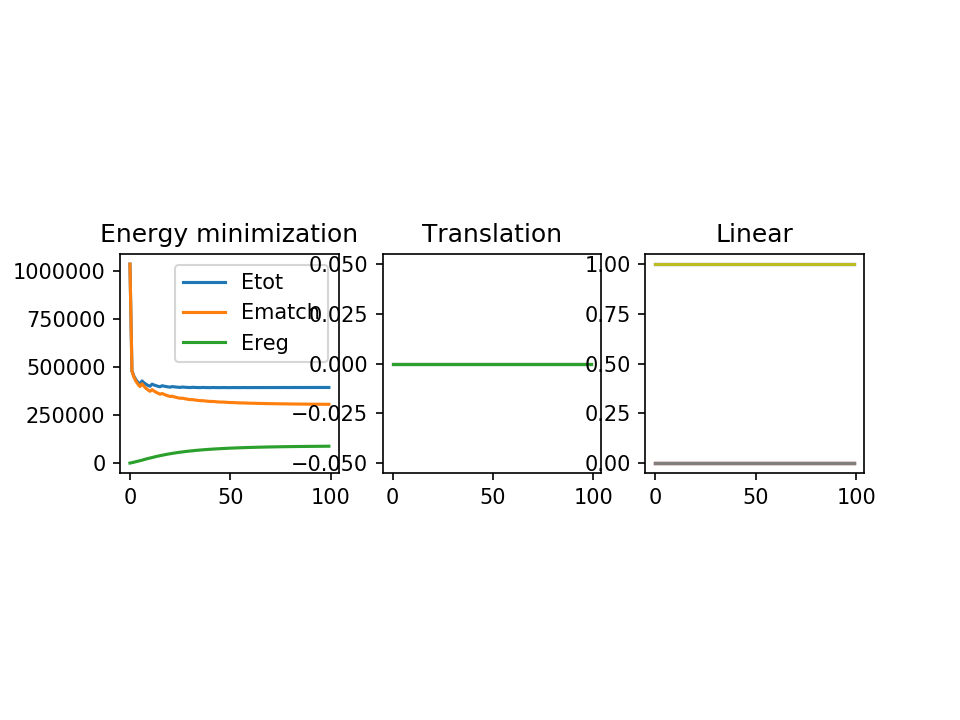

<IPython.core.display.Javascript object>


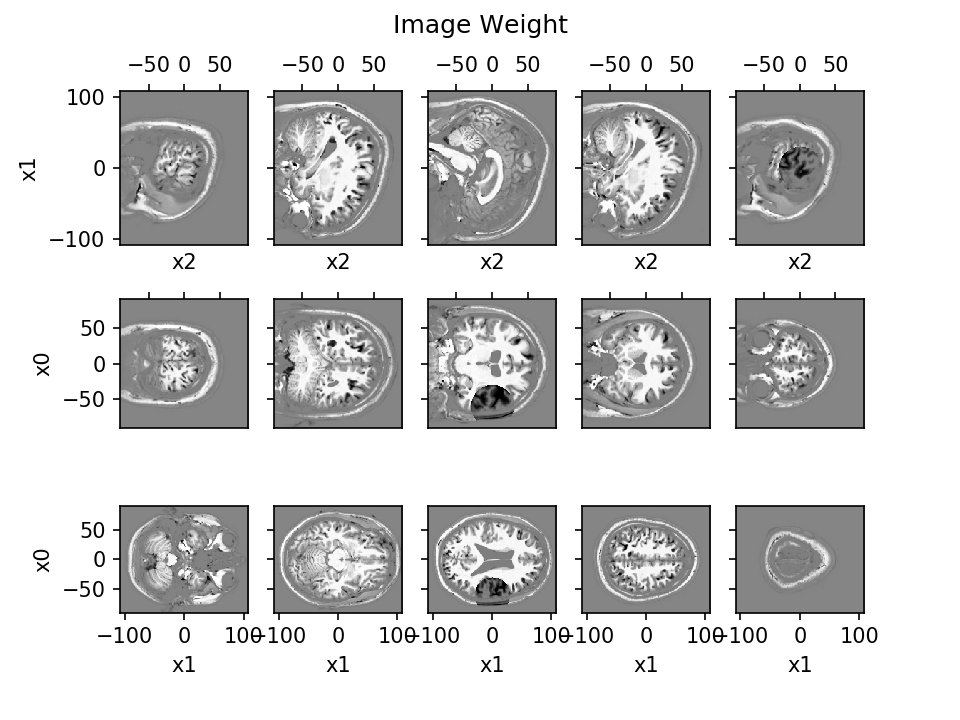

<IPython.core.display.Javascript object>


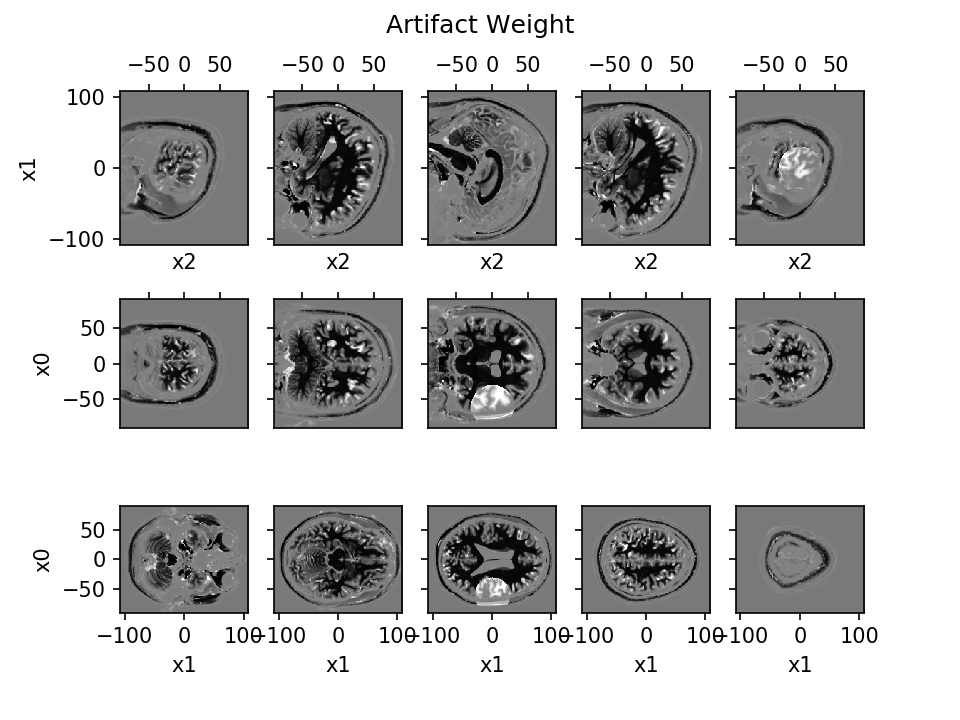

Taking affine and deformation step
Updating weights
Finished iteration 0, energy 1.037716e+06 (match 1.037716e+06, reg 0.000000e+00)
Taking affine and deformation step
Finished iteration 1, energy 4.811217e+05 (match 4.790609e+05, reg 2.060782e+03)
Taking affine and deformation step
Finished iteration 2, energy 4.522882e+05 (match 4.476923e+05, reg 4.595846e+03)
Taking affine and deformation step
Finished iteration 3, energy 4.341465e+05 (match 4.268908e+05, reg 7.255665e+03)
Taking affine and deformation step
Finished iteration 4, energy 4.213784e+05 (match 4.115010e+05, reg 9.877350e+03)
Taking affine and deformation step
Updating weights
Finished iteration 5, energy 4.117567e+05 (match 3.993364e+05, reg 1.242026e+04)
Taking affine and deformation step
Finished iteration 6, energy 4.283609e+05 (match 4.134859e+05, reg 1.487501e+04)
Taking affine and deformation step
Finished iteration 7, energy 4.183251e+05 (match 4.002036e+05, reg 1.812141e+04)
Taking affine and deformation step
Fin

Finished iteration 68, energy 3.939626e+05 (match 3.103148e+05, reg 8.364776e+04)
Taking affine and deformation step
Finished iteration 69, energy 3.939143e+05 (match 3.100459e+05, reg 8.386845e+04)
Taking affine and deformation step
Updating weights
Finished iteration 70, energy 3.938699e+05 (match 3.097936e+05, reg 8.407625e+04)
Taking affine and deformation step
Finished iteration 71, energy 3.941301e+05 (match 3.098578e+05, reg 8.427227e+04)
Taking affine and deformation step
Finished iteration 72, energy 3.940853e+05 (match 3.096042e+05, reg 8.448107e+04)
Taking affine and deformation step
Finished iteration 73, energy 3.940437e+05 (match 3.093671e+05, reg 8.467665e+04)
Taking affine and deformation step
Finished iteration 74, energy 3.940053e+05 (match 3.091449e+05, reg 8.486045e+04)
Taking affine and deformation step
Updating weights
Finished iteration 75, energy 3.939696e+05 (match 3.089361e+05, reg 8.503358e+04)
Taking affine and deformation step
Finished iteration 76, energy 

In [10]:
imp.reload(lddmm) # for debugging only
sigmaM = np.std(J)
out = lddmm.lddmm(I,J*(1.0-resected), # atlas and target images
                  xI=xI,xJ=xJ,
                  niter=100, # number of iterations of gradient descent                  
                  eV=1e-3*sigmaM**2, # step size for deformation field update
                  sigmaM=sigmaM, # noise in image (matching weight 1/2/sigmaM**2)
                  sigmaR=1e1, # noise in deformation (regularization weight 1/2/sigmaR**2)
                  p=2, # power of smoothing operator, 2 is typical
                  a=2.0, # length scale of smoothing operator (mm)
                  nMstep=5,
                  sigmaA=sigmaM, # std for "artifact" (aka missing tissue)
                  CA0=0.0 # artifact constant value
                 )
# note that Energy may not decrase, since we are using the EM algorithm to optimize 
# over incomplete data likelihood, while only calculating complete data likelihood